In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Ustawienia wyświetlania wykresów
%matplotlib inline

# Pobranie danych od 01-01-2019 do 31-12-2021
df = yf.download('ETH-USD', start='2019-01-01', end='2021-12-31')

# Użyjemy tylko kolumny 'Close' jako cechy
data = df[['Close']].values

data

[*********************100%***********************]  1 of 1 completed


array([[ 140.81941223],
       [ 155.04768372],
       [ 149.13500977],
       ...,
       [3800.89306641],
       [3628.53173828],
       [3713.85205078]])

In [9]:
# Skalowanie danych do zakresu (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)
# Definiowanie funkcji do tworzenia sekwencji danych
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

# Tworzenie sekwencji z look_back = 60 dni
look_back = 60
X, Y = create_dataset(scaled_data, look_back)




[[0.00770764]
 [0.01073007]
 [0.00947408]
 ...
 [0.78519742]
 [0.74858363]
 [0.76670776]]


In [10]:
# Reshape danych wejściowych do formatu [próbki, timesteps, cechy]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Podział na zbiór treningowy i testowy (80% treningowy, 20% walidacyjny)
train_size = int(len(X) * 0.7)
X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]



In [11]:
# Budowa modelu GRU
model = Sequential()
model.add(GRU(units=256, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.3))
model.add(GRU(units=128, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

# Kompilacja modelu
model.compile(loss='mean_squared_error', optimizer='adam')

# Trenowanie modelu z walidacją
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_val, Y_val), verbose=1)


C:\Users\Michał\Desktop\crypto_predict\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 60, 256)        │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 60, 128)        │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485,107 (1.85 MB)

 Trainable params: 485,107 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 780ms/step - loss: 0.0034 - val_loss: 0.0165
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 972ms/step - loss: 3.6627e-04 - val_loss: 0.0040
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 438ms/step - loss: 1.7554e-04 - val_loss: 0.0121
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - loss: 1.1614e-04 - val_loss: 0.0046
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 461ms/step - loss: 1.0350e-04 - val_loss: 0.0039
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 482ms/step - loss: 1.5543e-04 - val_loss: 0.0087
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - loss: 1.9559e-04 - val_loss: 0.0049
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - loss: 1.6308e-04 - val_loss: 0.0036
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step - loss: 1.5108e-04 - val_loss: 0.0085
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 615ms/step - loss: 1.7960e-04 - val_loss: 0.0033
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 504ms/step - loss: 1.4162e-04 - val_loss: 0.005

In [12]:
# Pobranie nowych danych dla okresu od 2022-01-01 do 2022-03-31
test_data = yf.download('ETH-USD', start='2022-01-01', end='2022-03-31')
actual_prices = test_data[['Close']].values

# Użycie danych do 31-12-2021, które są już w zmiennej df
train_close = df[['Close']].values

# Łączenie danych treningowych i testowych w celu utrzymania ciągłości
total_dataset = np.concatenate((train_close, actual_prices), axis=0)



[*********************100%***********************]  1 of 1 completed


In [13]:
# Przygotowanie danych do predykcji
inputs = total_dataset[len(total_dataset) - len(actual_prices) - look_back:]
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

# Tworzenie sekwencji danych do predykcji
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step


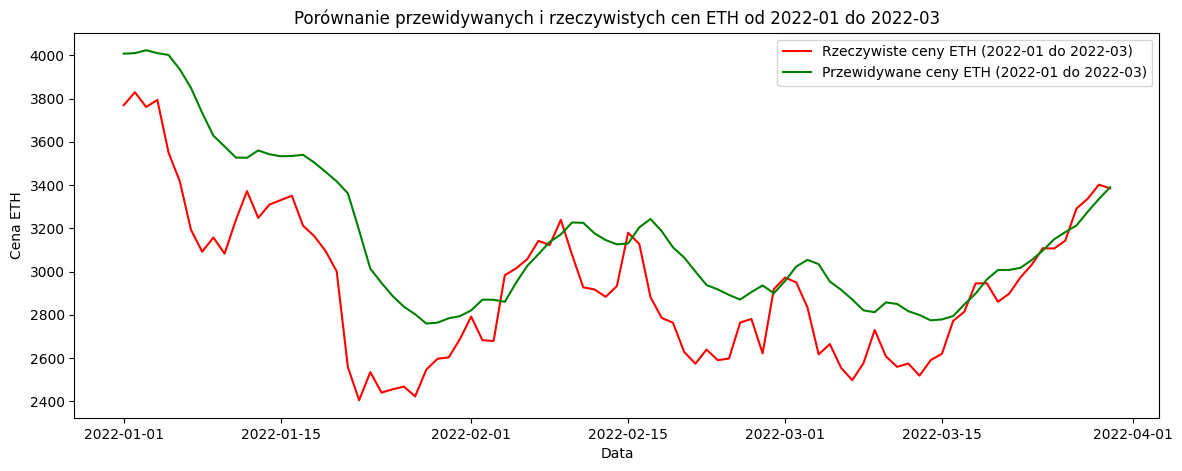

In [14]:
# Predykcja cen od 2022-01-01 do 2022-03-31
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Rzeczywiste ceny zamknięcia dla tego okresu
real_prices = test_data['Close'].values

# Daty dla okresu predykcji
test_dates = test_data.index

# Wykres porównujący rzeczywiste ceny z przewidywanymi
plt.figure(figsize=(14,5))
plt.plot(test_dates, real_prices, color='red', label='Rzeczywiste ceny ETH (2022-01 do 2022-03)')
plt.plot(test_dates, predicted_prices, color='green', label='Przewidywane ceny ETH (2022-01 do 2022-03)')
plt.title('Porównanie przewidywanych i rzeczywistych cen ETH od 2022-01 do 2022-03')
plt.xlabel('Data')
plt.ylabel('Cena ETH')
plt.legend()
plt.show()